# Real vs Fake face detection using Keras

This project aims to discriminate between **fake** images and **real** ones. This dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) that was provided by Bojan.

# Main Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [ ]:
tf.keras.backend.clear_session() #clean session

# Data Loading

The paths to the training, validation, and test sets have been specified below.

In [ ]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [ ]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis

Create a dictionary with three keys:
* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)    

In [ ]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [ ]:
images_df = pd.DataFrame(images_df)

In [ ]:
images_df

,folder,image_path,label
0,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
1,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
2,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
3,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
4,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
...,...,...,...
139995,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139996,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139997,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139998,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real


### Labels distribution

In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [ ]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [ ]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

As we can see fromt the results, the labels are equally distributed on each folder.

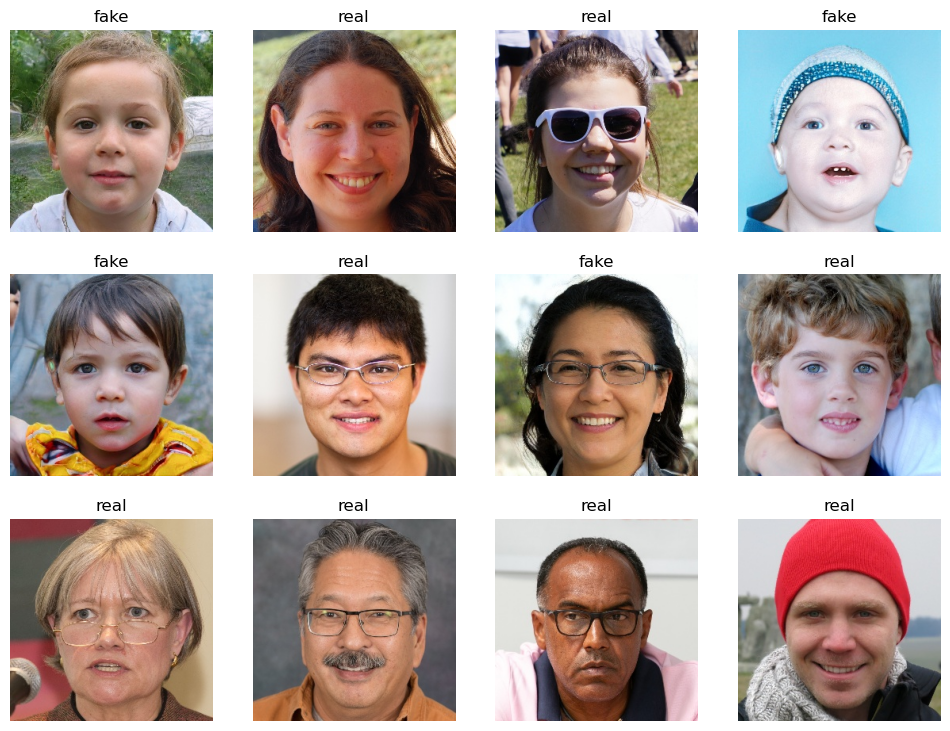

In [ ]:
plt.figure(figsize=(12, 9))


fake_images = images_df.sample(12)
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(plt.imread(fake_images["image_path"].values[i]))
    plt.title(fake_images["label"].values[i])
    plt.axis("off")

# Data Preparation for training

## Data Augmentation

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. Horizontal flip data augmentation is set to True in order to increase the size of a dataset by flipping images horizontally. This can help improve the accuracy of the model by exposing it to additional variations of the same images.

In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

Important! test_ds prediction and train_ds.classes (ground-truth) **will be not alligned** with suffle=True, so I need to disable shuffle for the test set.

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


It's visible that all the value are scaled.

In [ ]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.35686275 0.32941177 0.2901961 ]
  [0.34509805 0.31764707 0.2784314 ]
  [0.34901962 0.32156864 0.28235295]
  ...
  [0.34901962 0.3019608  0.25490198]
  [0.34901962 0.3019608  0.25490198]
  [0.34509805 0.29803923 0.2509804 ]]

 [[0.35686275 0.32941177 0.2901961 ]
  [0.36078432 0.33333334 0.29411766]
  [0.34509805 0.31764707 0.2784314 ]
  ...
  [0.3529412  0.30588236 0.25882354]
  [0.3529412  0.30588236 0.25882354]
  [0.3529412  0.30588236 0.25882354]]

 [[0.35686275 0.32156864 0.28627452]
  [0.34901962 0.3137255  0.2784314 ]
  [0.3529412  0.31764707 0.28235295]
  ...
  [0.35686275 0.30588236 0.27058825]
  [0.35686275 0.30980393 0.2627451 ]
  [0.35686275 0.30980393 0.2627451 ]]

 ...

 [[0.5529412  0.4431373  0.38823533]
  [0.6392157  0.5372549  0.48627454]
  [0.70980394 0.6313726  0.59607846]
  ...
  [0.39607847 0.2784314  0.18431373]
  [0.41960788 0.29803923 0.18823531]
  [0.43137258 0.29803923 0.19215688]]

 [[0.48627454 0.37254903 0.30980393]
  [0.60784316 0.5058824  0.4

Let's print the input shape:
- 32 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [ ]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [ ]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# CNN model architecture (DenseNet121)

In [ ]:
input_shape = (256, 256, 3) #define the input shape of our data

In [ ]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [ ]:
model_ft = get_model(input_shape)

model_ft.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
checkpoint_filepath = "model_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

The **EarlyStopping** callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau** callback reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

# Training

In [ ]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10
1563/1563 [==============================] - 833s 483ms/step - loss: 0.1234 - accuracy: 0.9505 - val_loss: 0.2286 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 2/10
1563/1563 [==============================] - 746s 477ms/step - loss: 0.0521 - accuracy: 0.9804 - val_loss: 0.1228 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 3/10
1563/1563 [==============================] - 744s 476ms/step - loss: 0.0392 - accuracy: 0.9861 - val_loss: 0.1429 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 4/10
1563/1563 [==============================] - 758s 485ms/step - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.1128 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 5/10
1563/1563 [==============================] - 743s 475ms/step - loss: 0.0290 - accuracy: 0.9894 - val_loss: 1.0803 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 6/10
1563/1563 [==============================] - 742s 475ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 0.0502 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 7/10
1563/1563 [============

# Results

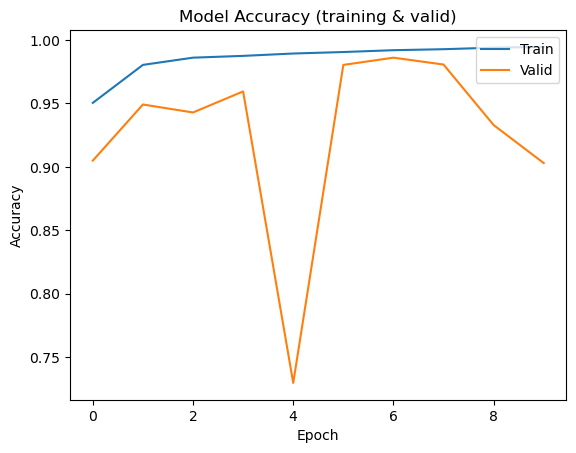

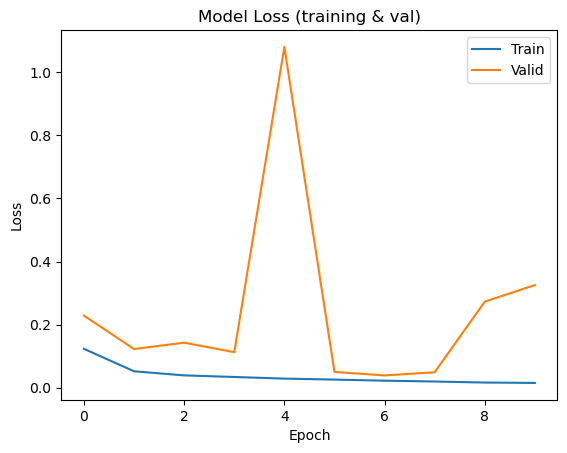

In [ ]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

The model is clearly overfitted. So wee have to restore the model weights from the ModelCheckpoint callback.

Let's try to evaluate the full overfitted model. We can see that it has a poor performance.

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 85s 270ms/step - loss: 0.3119 - accuracy: 0.9047
Test Loss: 0.3119257390499115
Test Accuracy: 0.9047499895095825


Here a ModelCheckpoint callback is necessary. Indeed loading the best weights results in a much better performance on the test set.

In [ ]:
model = get_model(input_shape)

# Restore the weights
model.load_weights('/content/drive/MyDrive/model_cp.h5')


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 75s 230ms/step - loss: 0.0387 - accuracy: 0.9868
Test Loss: 0.038666389882564545
Test Accuracy: 0.9867500066757202


# Image example - Qualitative results

Let's try the model on a real image. It is very confident (99.96%) that it is a real one.

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'This image is 0.04% Fake and 99.96% Real.')

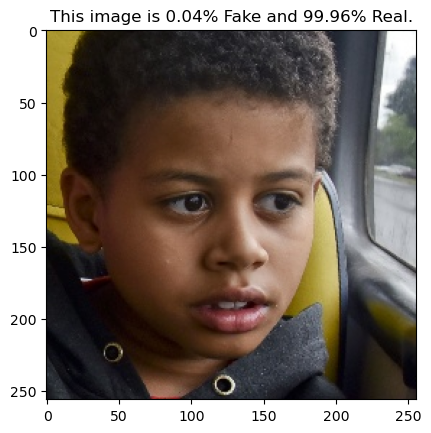

In [ ]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


The result score is near 1 if the image is **real** and 0 if the image is **fake**.

1/1 [==============================] - 0s 31ms/step


Text(0.5, 1.0, 'This image is 99.46% Fake and 0.54% Real.')

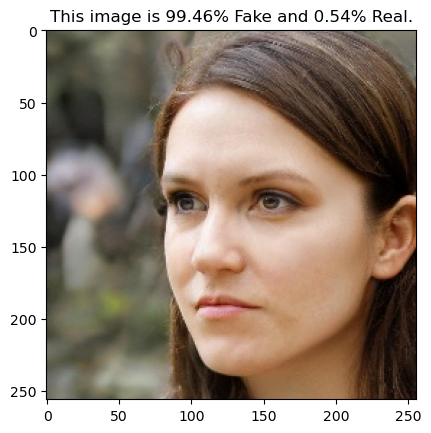

In [ ]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

#fake example
test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

# Quantitative results

In [ ]:
# Assuming you have defined your model as 'model'
predicted_labels = model.predict(test_ds)

313/313 [==============================] - 73s 225ms/step


In [ ]:
true_labels = test_ds.classes

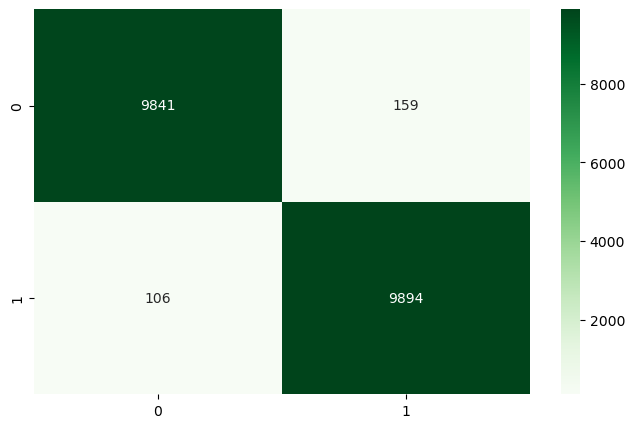

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [ ]:
metrics.accuracy_score(true_labels, predicted_labels.round())

0.98675

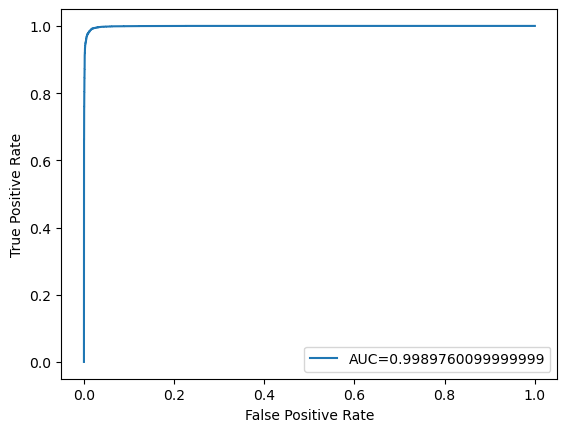

In [ ]:
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()